## Quick test -- M fixed and known

In [168]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMCGibbs
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as random
from jax.config import config
from tqdm import tqdm
import ott
from ott.geometry.geometry import Geometry
from ott.solvers.linear import sinkhorn
import matplotlib.pyplot as plt
config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

In [173]:
# Dimensions of the marginals
M, N = 18, 21

# Remember that we're not observing a probability distribution, but actual counts -- they need to be large.
# Observations of marginal propbabilities would require a bit of a different model
num_observations = 1000


# Define "true" marginals
mu = num_observations*jnp.ones(M) / M # uniform marginal

nu = jnp.array([i**2 for i in range(1, N+1)]) 
nu = num_observations*nu / jnp.sum(nu)

# Define "true" cost
iota = 1e-6
C = jnp.array([[iota + (i - j)**2 for j in range(N)] for i in range(M)], dtype=jnp.float64)

# Normalize cost
C = C/C.sum(axis=0, keepdims=True)

# Generate a transport plan
eps = 5e-2
T = sinkhorn.solve(Geometry(cost_matrix=C, epsilon=eps), a=mu, b=nu).matrix

# Generate A and B
A, B = T.sum(axis=1), T.sum(axis=0)

# exp(-C/epsilon)
M = jax.lax.exp(-C/eps)

/var/folders/6t/lwnd4g753ln6ny4tz644hvf40000gp/T/ipykernel_40634/2052984781.py:19: DeprecationWarning: `solve` will be removed in the next release. Please use `ott.solvers.linear.solve()` instead.
  T = sinkhorn.solve(Geometry(cost_matrix=C, epsilon=eps), a=mu, b=nu).matrix


In [174]:

# Define prior parameters
u_0, v_0 = 0.0, 1e-9
u_1, v_1 = 0.0, 1e-9
u_2, v_2 = 0.0, 1e-9

key, key_a, key_b, key_c = random.split(key, 4)

# Draw an initial guess
alpha = numpyro.sample("alpha", dist.Gamma(u_0, v_0), rng_key=key_a, sample_shape=mu.shape)
beta = numpyro.sample("beta", dist.Gamma(u_1, v_1), rng_key=key_b, sample_shape=nu.shape) 

#Make an initial guess for M
#_M = jnp.ones((M, N))
# _M /= _M.sum(axis=0, keepdims=True)
# _M = jax.lax.exp(-_M/eps)

# Collect samples
alpha_res, beta_res, y_res, M_res = [], [], [], []

# Model definition
def Gibbs(_a, _b, _m, _key_a, _key_b, _key_c):
     _alpha = numpyro.sample("alpha", dist.Gamma(A + u_0 , v_0 + jnp.matmul(_m, _b)), rng_key=_key_a)
     _beta = numpyro.sample("beta", dist.Gamma(B + u_1 , v_1 + jnp.matmul(_alpha, _m)), rng_key=_key_b)
     _a_b = _alpha.reshape(-1, 1) * _beta.reshape(1, -1)
     _y = _a_b * _m
    # _m_new = numpyro.sample("_M", dist.Gamma(_y + u_2, _a_b+ v_2), rng_key=_key_c)
     return _alpha, _beta, _y#, _m_new

# Let's gooooooo
n_samples, burn_in = 100000, 100
for _ in tqdm(range(n_samples), desc="Sampling"):
    key, key_a, key_b, key_c = random.split(key, 4)
    alpha, beta, _y= Gibbs(alpha, beta, M, key_a, key_b, key_c)
    if _ > burn_in:
        alpha_res.append(alpha)
        beta_res.append(beta)
        y_res.append(_y)
        #M_res.append(_M)

Sampling: 100%|██████████| 100000/100000 [00:23<00:00, 4181.64it/s]


Text(0.5, 1.0, 'recovered marginal 2')

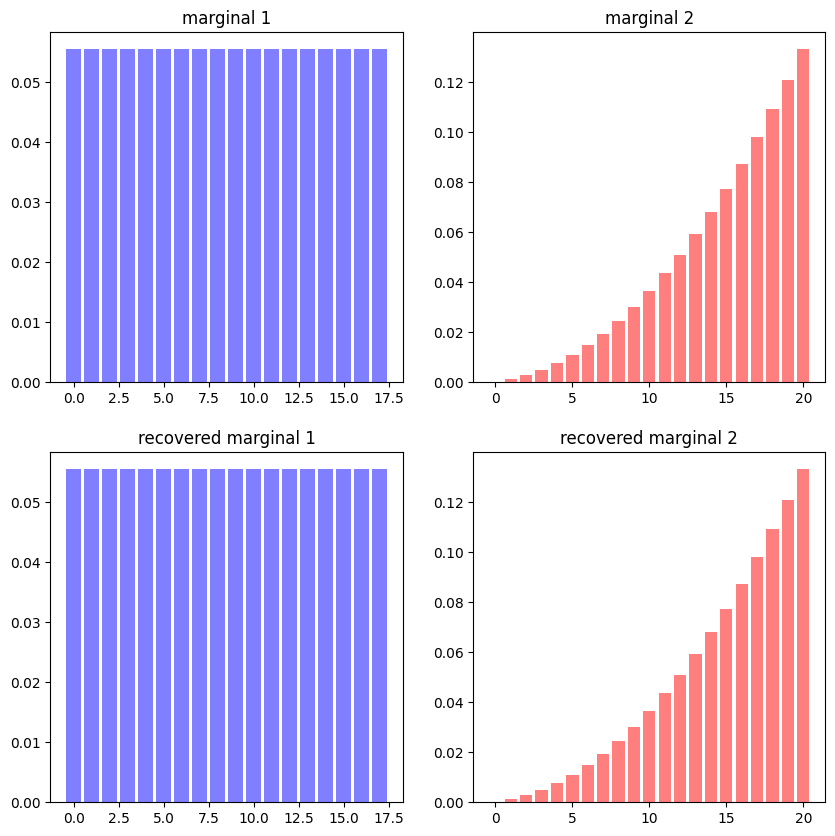

In [175]:
# alpha and beta aren't the marginals, but rather the row and column scaling of the transport plan
T_av = np.array(y_res).mean(axis=0)

# plot the marginals
fig, axs = plt.subplots(2,2, figsize=(10, 10))
axs[0, 0].bar(range(mu.shape[0]), mu/np.sum(mu), color='blue', alpha=0.5)
axs[0, 0].set_title('marginal 1')

axs[0, 1].bar(range(nu.shape[0]), nu/np.sum(nu), color='red', alpha=0.5)
axs[0, 1].set_title('marginal 2')

alpha_est = T_av.sum(axis=1) #np.array(alpha_res).mean(axis=0)
alpha_est /= np.sum(alpha_est)
axs[1, 0].bar(range(alpha.shape[0]), alpha_est, color='blue', alpha=0.5)
axs[1, 0].set_title('recovered marginal 1')

beta_est = T_av.sum(axis=0) #np.array(beta_res).mean(axis=0)
beta_est /= np.sum(beta_est)
axs[1, 1].bar(range(beta.shape[0]), beta_est, color='red', alpha=0.5)
axs[1, 1].set_title('recovered marginal 2')

Text(0.5, 1.0, 'Inferred transport map')

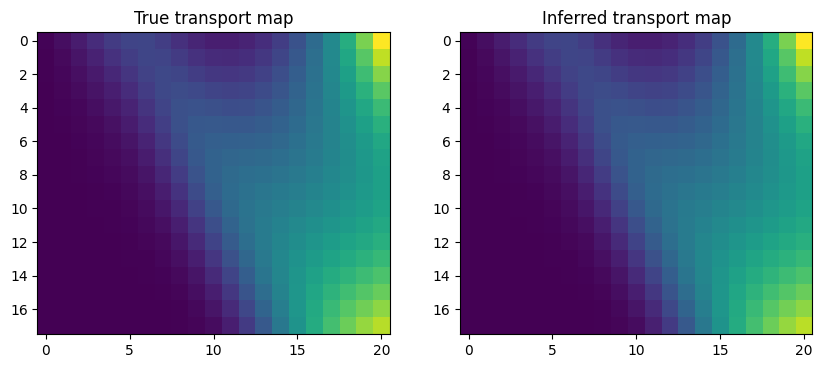

In [176]:
### this is resolved ok.
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
axs[0].imshow(T)
axs[0].set_title("True transport map")
axs[1].imshow(T_av)
axs[1].set_title("Inferred transport map")

In [127]:
## ignore quick test
def Sinkhorn(C, mu, nu, lamb, Niter=1000):
    # lam : strength of the entropic regularization

    N = len(mu)
    M = len(nu)
    
    #Initialization
    a1 = np.zeros(N)
    b1 = np.zeros(M)
    a2 = np.ones(N)
    b2 = np.ones(M)
    Iter = 0

    GammaB = np.exp(-lamb*C)

    #Sinkhorn
    while (Iter < Niter):
        a1 = a2
        b1 = b2
        a2 = (mu-1)/(np.dot(GammaB,b1))
        b2 = (nu-1)/(np.dot(GammaB.T,a2))
        Iter +=1

    # Compute gamma_star
    Gamma = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            Gamma[i][j] = a2[i]*b2[j]*GammaB[i][j]
    Gamma /= Gamma.sum()

    return Gamma